# Preprocessing and building a simple ML pipeline

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. In this notebook I will do a demo of data preprocessing and building a simple supervised machine learning pipeline on a real-world dataset.

## Imports

In [1]:
import altair as alt
alt.data_transformers.enable('data_server')
alt.renderers.enable("mimetype")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

<br><br>

## 1: The dataset 
<hr>

In this exercise I will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. More information on the dataset and features can be found [here](http://archive.ics.uci.edu/ml/datasets/Adult).


In [2]:
census_df = pd.read_csv("../downloads/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. Usually having more data for training is a good idea. But here I'm using 60%/40% split because this is kind of a big dataset for a modest laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!


In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

<br><br>

## 2: Exploratory data analysis (EDA)  
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


We see some missing values represented with a "?". Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So we'll replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


<br><br>

### 2.1 Visualizing features

We will visualize the histograms of numeric features. Alternatively, we could have used [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA.

In [7]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


In [8]:
train_df_nan.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.592547,1.892662e+05,10.084767,1090.443540,86.537162,40.532606
std,13.638971,1.049020e+05,2.580723,7449.700833,402.395668,12.406636
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782835e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.368860e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education.num'}>,
        <AxesSubplot:title={'center':'capital.gain'}>],
       [<AxesSubplot:title={'center':'capital.loss'}>,
        <AxesSubplot:title={'center':'hours.per.week'}>]], dtype=object)

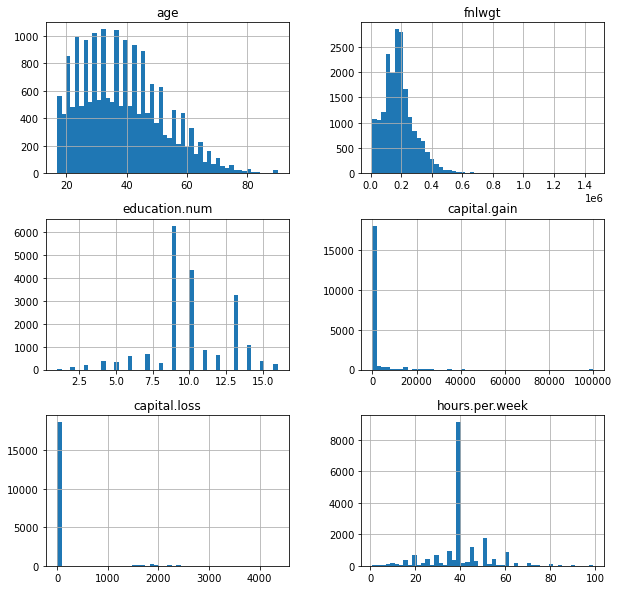

In [9]:
numeric_cols = train_df_nan.select_dtypes("int64").columns.tolist()

train_df_nan.hist(bins=50,figsize=(10,10))

Age and fnlwgt (and maybe education.num) seem to be the most relevant features. The rest are not distributed well and are concentrated at one value._ 

<br><br>

### 2.2 Identify transformations to apply

Next, I identify the sequence of transformations that I would apply on each column in the dataset. I am droping education because education.num carries the same data but in a preferable numeric format. I am also dropping capital.gain and capital loss due to high concentration of values around 0.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | scaling |
| workclass | imputation, OHE |
| fnlwgt | scaling |
| education | drop |
| education.num | scaling |
| marital.status | OHE |
| relationship | OHE |
| race | OHE |
| sex | OHE |
| capital.gain | drop |
| capital.loss | drop |
| hours.per.week | scaling |
| native.country | Imputation, OHE |


<br><br>

### 2.3 Feature types 



In [10]:
numeric_features = ["age", "fnlwgt", "education.num", "hours.per.week"]
categorical_features = [
    "occupation",
    "workclass",
    "marital.status",
    "relationship",
    "race",
    "native.country",
]
ordinal_features = []
binary_features = ["sex"]
drop_features = ["education", "capital.gain", "capital.loss"]
passthrough_features = []
target = "income"

<br><br>

### 2.4 Race feature
 
Ethically, including race feature should not be a good idea and has been in radar for many organizations to build racial equality in recent years. However, realistically speaking, since this data is from 1994 when importance of racial equality was not publicly discussed, this feature could still be of use income prediction.

<br><br>

### 2.5 Separating feature vectors and targets  


In [11]:
X_train = train_df_nan.drop("income", axis=1)
y_train = train_df_nan["income"]
X_test = test_df_nan.drop("income", axis=1)
y_test = test_df_nan["income"]

Note that at this stage training a Support Vectore Classifier (SVC) won't work because SVC only accepts numerical values for train data. As the name indicates, SVM is designed to find the proximity to support vectors (numeric), and the notion of distance from a string (category) is not defined.

<br><br>

## 3: Preprocessing 
<hr>


### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`


let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Alternatively, we can use `make_pipeline` and `make_column_transformer` which are my recommendation because of the naming of processes.  


In [12]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (
        make_pipeline(
            SimpleImputer(strategy="constant", fill_value="missing"),
            OneHotEncoder(sparse=False, handle_unknown="ignore"),
        ),
        categorical_features,
    ),
    (OneHotEncoder(sparse=False, drop="if_binary"), binary_features),
    ("drop", drop_features),
)

In [13]:
X_train_trans = preprocessor.fit_transform(X_train)

pd.DataFrame(
    X_train_trans,
    columns=numeric_cols
    + preprocessor.named_transformers_["pipeline"]["onehotencoder"]
    .get_feature_names()
    .tolist()
    + ["male"],
)

C:\Users\artan\miniconda3\envs\571\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,x0_Adm-clerical,x0_Armed-Forces,x0_Craft-repair,x0_Exec-managerial,...,x5_Scotland,x5_South,x5_Taiwan,x5_Thailand,x5_Trinadad&Tobago,x5_United-States,x5_Vietnam,x5_Yugoslavia,x5_missing,male
0,-0.190089,0.536275,-2.357837,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.923301,-0.524114,0.354651,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.996622,-0.760159,-0.420345,-0.146378,-0.215060,-0.204138,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.143264,-0.552827,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.849979,0.036757,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19531,-0.996622,2.106533,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19532,0.909729,-0.405142,0.354651,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19533,1.203014,0.466408,-0.420345,-0.146378,4.474474,-0.042930,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19534,0.176517,-0.335466,-0.032847,-0.146378,-0.215060,0.763111,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<br><br>

### 3.2 Discussion


One of the biggest advantages of pipelines in case of this example is that we can use it to construct a combination of multiple transformations which we could use to apply to one set of columns. Without this feature we wouldn't be able to call the resultant nd_array from the first transformation in order to call another transformation on.   
Column transformers in this case are very handy because we have different column types from numeric to categorical where we want to have different tranformations for each or even drop some columns. Combination of pipeline and column transformer not only make the transformation of test data easy, but will also allow us to run cross_validate function without any leak (of test data).

<br><br>

## 4: Building models 
<hr>

Now that we have preprocessed features, we are ready to build models. I'm using the helper function inspired by UBC MDS lecture material. Using this function we  return mean cross-validation score along with standard deviation for a given model.

In [14]:
results_dict = {}  # dictionary to store all the results

In [15]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 

1. We define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with default hyperparameters as our classifier.  
2. We carry out 5-fold cross-validation with the pipeline, and store the results in `results_dict` above.


In [16]:
dummy = make_pipeline(preprocessor, DummyClassifier())

results_dict = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, cv=5
)
pd.DataFrame(results_dict, columns=["value"])

,value
fit_time,0.055 (+/- 0.009)
score_time,0.026 (+/- 0.006)
test_score,0.760 (+/- 0.000)
train_score,0.760 (+/- 0.000)


<br><br>

### 4.2 Trying different classifiers

For each of the models in the `models` dictionary below we:  
- define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
- carry out 5-fold cross-validation with the pipeline.  
- store mean cross-validation scores, mean train scores, and `fit()` and `score()` times in `results_dict`. 


In [17]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

In [18]:
results_dict = pd.DataFrame()
for key, pair in models.items():
    pipe = make_pipeline(preprocessor, pair)

    result = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, cv=5
    )
    results_dict = pd.concat(
        [results_dict, pd.DataFrame(result, columns=[key])], axis=1
    )

results_dict

,decision tree,kNN,RBF SVM
fit_time,0.227 (+/- 0.010),0.063 (+/- 0.014),11.572 (+/- 0.221)
score_time,0.024 (+/- 0.008),1.448 (+/- 0.091),3.234 (+/- 0.398)
test_score,0.814 (+/- 0.007),0.831 (+/- 0.002),0.855 (+/- 0.005)
train_score,1.000 (+/- 0.000),0.882 (+/- 0.001),0.867 (+/- 0.001)


<br><br>

### 4.3 Discussion
 

As expected with Decision Trees if we do not specify depth, we will get a perfect train score of 1 which is much higher than the other two. Decision tree is also the one with fastest score time. On the other side RBF SVM appears to have found a more balanced fit with lower train score but highest mean cross validation score. Fit time is the lowest for KNN as expected since the model will only be storing the values. 

<br><br>

### 4.4 Hyperparameter optimization

In this exercise, we'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice we carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. Here we'll only do it for the `SVC` classifier for one hyperparameter: `C`. 


In [19]:
param_grid = {"C": np.logspace(-2, 2, 4)}

In [20]:
results_dict = pd.DataFrame()
for c in param_grid["C"]:
    pipe = make_pipeline(preprocessor, SVC(random_state=123, C=c))
    result = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, cv=5
    )
    results_dict = pd.concat(
        [results_dict, pd.DataFrame(result, columns=[f"C = {round(c,2)}"])], axis=1
    )

results_dict

,C = 0.01,C = 0.22,C = 4.64,C = 100.0
fit_time,14.787 (+/- 0.466),11.665 (+/- 0.159),13.420 (+/- 0.377),28.425 (+/- 0.841)
score_time,4.601 (+/- 0.112),3.455 (+/- 0.061),3.080 (+/- 0.194),3.319 (+/- 0.123)
test_score,0.818 (+/- 0.004),0.854 (+/- 0.006),0.855 (+/- 0.006),0.838 (+/- 0.004)
train_score,0.819 (+/- 0.003),0.858 (+/- 0.001),0.881 (+/- 0.002),0.918 (+/- 0.001)


The default C value used by scikit-learn was 1 which gave the exact same score as my highest CV score of 0.855 (for C = 4.46) in this hyperparameter tuning exercise. 

<br><br>

### 4.5 Hyperparameter optimization for other models

Now we go further by doing extra hyperparameter optimization. We will:
1. Jointly optimize `C` and `gamma` hyperparameters of SVC. 
2. Carry out hyperparameter optimization for other classifiers.  
3. Comment on your results. Are you getting a better model? 

> Note: In later notebooks I will use proper hyperparameter optimization using `sklearn`'s **`RandomizedSearchCV`** and **`GridSearchCV`** instead a nested for loop. Running the below code you will see that for loops are not very optimized when it comes to calculating cross validation scores.

In [21]:
def mean_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append(mean_scores[i])

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
gammas = [0.01, 0.1, 1]
C = [0.01, 1, 100]

results = pd.DataFrame()
for gamma in gammas:
    for c in C:
        pipe = make_pipeline(preprocessor, SVC(random_state=123, C=c, gamma=gamma))
        result = mean_cross_val_scores(pipe, X_train, y_train, cv=5)
        result_df = pd.DataFrame(
            [c, gamma, result[2]], index=["C", "gamma", "CV_score"]
        )

        results = pd.concat([results, result_df], axis=1)

In [23]:
results.T.pivot(index="C", columns="gamma", values="CV_score")

gamma,0.01,0.10,1.00
C,,,
0.01,0.764947,0.815827,0.759674
1.00,0.853758,0.855191,0.817414
100.00,0.854423,0.834767,0.794124


According to the scores above it seems like a gamma value of 0.1 and C value of 1 gives the best performance. This score is very identical to the validation score from default SVC hyperparameters.

<br><br><br><br>

## 5: Evaluating on the test set
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. We'll examine whether the results we obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 



In [25]:
final_pipe = make_pipeline(preprocessor, SVC(random_state=123, C=1, gamma=0.1))

final_pipe.fit(X_train, y_train)
final_score = final_pipe.score(X_test, y_test)
print("The test score for our optimized model is {0:.3f}".format(final_score))

The test score for our optimized model is 0.856


<br><br>

### 5.2 Conclusion



- The cross_validation score and test score are very consistent showing that the model is generalizing well.
- Considering the high number of training data and similar scores for CV and test data, I am confident that this model will perform similar on deployment data.

<br><br><br><br>